In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import Counter, OrderedDict

import cv2
import skimage
from skimage.io import imread
from PIL import Image

import torch
from torch import nn
from torch.nn import Sequential
from torch.nn import functional as F
from torchvision import transforms, models

## Raw data explore

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = np.load('drive/MyDrive/Colab Notebooks/YSDA Sem 3/CV/10_Cars_detector/train_data.npz')

In [ ]:
data['X'].shape, Counter(data['y'])

((1050, 40, 100, 1), Counter({0: 500, 1: 550}))

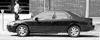

In [ ]:
Image.fromarray(np.uint8(data['X'][2][...,0]*255))

## Simple classifier

In [ ]:
def get_cls_model(input_shape):
    """
    :param input_shape: tuple (n_rows, n_cols, n_channels)
            input shape of image for classification
    :return: nn model for classification
    """
    # your code here \/
    H, W, C = input_shape
    model = Sequential(OrderedDict([
        ('conv', nn.Conv2d(C, 8, (3, 3), stride=1, padding='same')),
        ('relu_1', nn.ReLU()),
        ('bn', nn.BatchNorm2d(8)),
        ('maxpool', nn.MaxPool2d((4, 4), stride=4)),
        ('flatten', nn.Flatten(1, -1)),
        ('fc1', nn.Linear(8*(H//4)*(W//4), 128, bias=False)),
        ('relu_2', nn.ReLU()),
        ('dropout', nn.Dropout(0.1)),
        ('fc2', nn.Linear(128, 2, bias=False))
    ]))
    return model


def fit_cls_model(X, y):
    """
    :param X: 4-dim tensor with training images
    :param y: 1-dim tensor with labels for training
    :return: trained nn model
    """
    # your code here \/
    N, C, H, W = X.shape
    model = get_cls_model((H, W, C))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    N_EPOCH = 20
    BATCH_SIZE = 64
    ITERS = N // BATCH_SIZE + 1

    for epoch in range(N_EPOCH):
        running_loss = 0

        for i in range(ITERS):
            data = X[BATCH_SIZE*i:BATCH_SIZE*(i+1)]
            labels = y[BATCH_SIZE*i:BATCH_SIZE*(i+1)]

            augmentation = transforms.Compose([
                transforms.RandomInvert(p=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=15),
                transforms.ColorJitter(brightness=(0.75, 1.25))
            ])
            data = augmentation(data)

            optimizer.zero_grad()
            logits = model(data)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'[Epoch {epoch+1}] loss: {running_loss:.3f}')

    return model

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = data['X'].reshape(-1, 1, 40, 100)   #pytorch dimensions are (N, C, H, W)
y = data['y'].astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train, X_test = torch.from_numpy(X_train), torch.from_numpy(X_test)
y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)

cls_model = fit_cls_model(X_train, y_train)
y_predicted = torch.argmax(cls_model(X_test), dim=1)
accuracy = accuracy_score(y_test, y_predicted)

print('-'*20)
print(f'Accuracy = {accuracy:.3f}')

if accuracy > 0.95:
    torch.save(cls_model, "classifier_model.pth")

[Epoch 1] loss: 11.304
[Epoch 2] loss: 8.003
[Epoch 3] loss: 6.167
[Epoch 4] loss: 5.322
[Epoch 5] loss: 4.099
[Epoch 6] loss: 3.750
[Epoch 7] loss: 3.452
[Epoch 8] loss: 2.996
[Epoch 9] loss: 2.070
[Epoch 10] loss: 2.120
[Epoch 11] loss: 2.169
[Epoch 12] loss: 2.062
[Epoch 13] loss: 1.815
[Epoch 14] loss: 1.811
[Epoch 15] loss: 1.420
[Epoch 16] loss: 1.539
[Epoch 17] loss: 1.121
[Epoch 18] loss: 1.249
[Epoch 19] loss: 1.474
[Epoch 20] loss: 1.433
--------------------
Accuracy = 0.973


## Heatmap extractor

In [ ]:
def get_detection_model(cls_model):
    """
    :param cls_model: trained cls model
    :return: fully convolutional nn model with weights initialized from cls
             model
    """
    # your code here \/
    conv_fc1 = nn.Conv2d(8, 128, (10, 25), padding='valid') # no padding
    conv_fc2 = nn.Conv2d(128, 2, (1, 1), padding='valid') # no padding
    
    with torch.no_grad():
        conv_fc1.weight = torch.nn.Parameter(cls_model.fc1.weight.reshape(128, 8, 10, 25))
        conv_fc2.weight = torch.nn.Parameter(cls_model.fc2.weight.reshape(2, 128, 1, 1))

    detection_model = Sequential(OrderedDict([
        ('conv', cls_model.conv),
        ('relu_1', cls_model.relu_1),
        ('bn', cls_model.bn),
        ('maxpool', cls_model.maxpool),  
        # shape after CNN part = [batch_size, 8, 10, 25]
        # it's 8 feature maps sized 10x25
        ('conv_fc1', conv_fc1),
        ('relu_2', cls_model.relu_2),
        ('dropout', cls_model.dropout),
        ('conv_fc2', conv_fc2),
        ('activation', nn.Softmax(dim=1)),
    ]))
    # output shape = [batch_size, 2, 1, 1]
    return detection_model

In [ ]:
detection_model = get_detection_model(cls_model)
detection_model.eval()

detection_model(torch.tensor(X[:1]))

tensor([[[[9.9981e-01]],

         [[1.9355e-04]]]], grad_fn=<SoftmaxBackward0>)

In [ ]:
!cp drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 3/CV/10_Cars_detector/true_detections.json true_detections.json
!cp drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 3/CV/10_Cars_detector/test_imgs.zip test_imgs.zip
!unzip -q test_imgs.zip

In [ ]:
def read_for_detection(img_dir, gt_path):
    from skimage.io import imread
    from json import load

    raw_data = load(open(gt_path))
    data = {}
    for file_name, bboxes in raw_data.items():
        data[file_name] = [skimage.img_as_float32(imread(os.path.join(img_dir, file_name))), bboxes]
    return data

In [ ]:
data = read_for_detection('test_imgs', 'true_detections.json')

Image = (115, 210), heatmap = (19, 28)


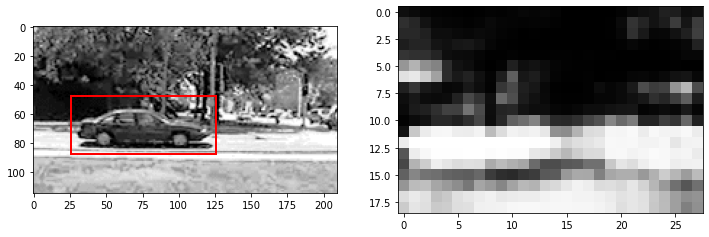

In [ ]:
img = data['test-0.png'][0]
h, w, height, width = data['test-0.png'][1][0]

img_tensor = torch.tensor(img).expand(1, 1, *img.shape)
detection = detection_model(img_tensor)
detection = detection[0][1].detach().numpy()
print(f'Image = {img.shape}, heatmap = {detection.shape}')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(img, cmap='gray')
ax[0].add_patch(Rectangle((w, h), width, height, linewidth=2, edgecolor='r', facecolor='none'))
ax[1].imshow(detection, cmap='gray')

plt.show()

## Detector

In [ ]:
def get_detections(detection_model, dictionary_of_images):
    """
    :param detection_model: trained fully convolutional detector model
    :param dictionary_of_images: dictionary of images in format
        {filename: ndarray}
    :return: detections in format {filename: detections}. detections is a N x 5
        array, where N is number of detections. Each detection is described
        using 5 numbers: [row, col, n_rows, n_cols, confidence].
    """
    # your code here \/
    def pad_image(image):
        h, w = image.shape
        padded = np.zeros((220, 370), dtype='float64')
        padded[:h,:w] = image
        return padded
    
    STRIDE = 4
    RECEPTIVE_H, RECEPTIVE_W = 40, 100
    THRESHOLD = 0.9

    detections = {}
    detection_model.eval()
    images = [(pad_image(img), img.shape) for img in dictionary_of_images.values()]

    for filename, (image_padded, original_shape) in zip(dictionary_of_images.keys(), images):
        img_tensor = torch.tensor(image_padded).expand(1, 1, *image_padded.shape)

        detection = detection_model(img_tensor.float())
        detection = detection[0][1].detach().numpy()
        detected = np.argwhere(detection >= THRESHOLD)
        bboxes = [[h*STRIDE, w*STRIDE, RECEPTIVE_H, RECEPTIVE_W, detection[h,w]] for h, w in detected]
        bboxes_filtered = [
            bb for bb in bboxes 
            if (bb[0]+RECEPTIVE_H <= original_shape[0]) & 
               (bb[1]+RECEPTIVE_W <= original_shape[1])
        ]
        detections[filename] = bboxes_filtered
        assert len(bboxes_filtered) > 0, 'Filtered too many predicted bboxes!'
    
    return detections

In [ ]:
dictionary_of_images = {k: v[0] for k, v in data.items()}
detections = get_detections(detection_model, dictionary_of_images)

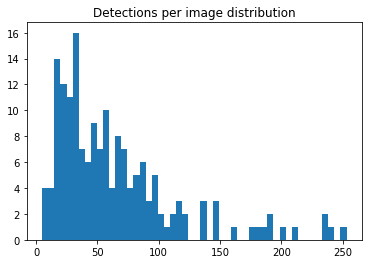

In [ ]:
plt.hist(list(map(len, detections.values())), bins=50)
plt.title('Detections per image distribution')
plt.show()

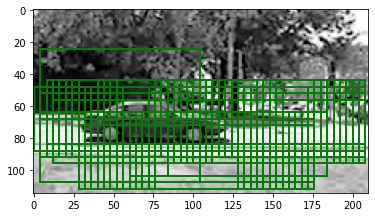

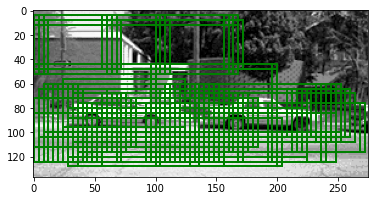

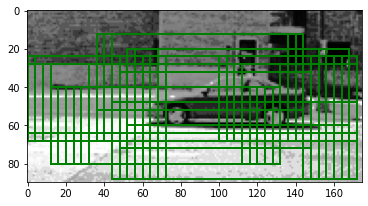

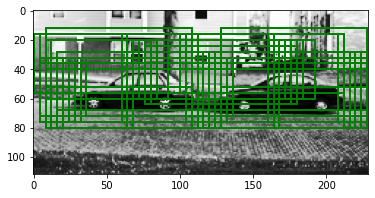

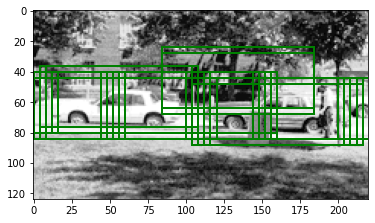

In [ ]:
i = 0
for filename, dets in detections.items():
    img = dictionary_of_images[filename]
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    for det in dets:
        h, w, height, width, _ = det
        ax.add_patch(Rectangle((w, h), width, height, linewidth=2, edgecolor='g', facecolor='none'))
    i += 1
    if i == 5:
        break

## IOU

In [ ]:
def calc_iou(first_bbox, second_bbox):
    """
    :param first bbox: bbox in format (row, col, n_rows, n_cols)
    :param second_bbox: bbox in format (row, col, n_rows, n_cols)
    :return: iou measure for two given bboxes
    """
    # your code here \/
    row_1, col_1, n_rows_1, n_cols_1 = map(int, first_bbox)
    row_2, col_2, n_rows_2, n_cols_2 = map(int, second_bbox)
    
    # if negative - shift bboxes into positive area
    row_shift = max(0, -row_1, -row_2)
    col_shift = max(0, -col_1, -col_2)

    bbox_1 = np.zeros((220, 370), dtype=bool)
    bbox_1[row_1+row_shift:row_1+row_shift+n_rows_1, 
           col_1+col_shift:col_1+col_shift+n_cols_1] = 1

    bbox_2 = np.zeros((220, 370), dtype=bool)
    bbox_2[row_2+row_shift:row_2+row_shift+n_rows_2, 
           col_2+col_shift:col_2+col_shift+n_cols_2] = 1

    intersection = (bbox_1 & bbox_2).sum()
    union = (bbox_1 | bbox_2).sum()

    return intersection / union

In [ ]:
calc_iou([56, -10, 40, 100], [56.0, 0.0, 40.0, 100.0])

0.8181818181818182

## AUC

In [ ]:
def calc_auc(pred_bboxes, gt_bboxes):
    """
    :param pred_bboxes: dict of bboxes in format {filename: detections}
        detections is a N x 5 array, where N is number of detections. Each
        detection is described using 5 numbers: [row, col, n_rows, n_cols,
        confidence].
    :param gt_bboxes: dict of bboxes in format {filenames: bboxes}. bboxes is a
        list of tuples in format (row, col, n_rows, n_cols)
    :return: auc measure for given detections and gt
    """
    # your code here \/
    IOU_THR = 0.5
    TP, FP = {}, {}
    N_rectangles = 0

    for filename, detections in pred_bboxes.items():
        # (1.a)
        detections_sorted = sorted(detections, key=lambda x: x[-1], reverse=True)
        true_bboxes = gt_bboxes[filename].copy()
        N_rectangles += len(true_bboxes)
        # (1.b)
        TP[filename] = []
        FP[filename] = []
        for pred in detections_sorted:
            iou_best = 0
            index_best = None
            for i, true in enumerate(true_bboxes):
                iou = calc_iou(pred[:4], true)
                if iou > iou_best:
                    iou_best = iou
                    index_best = i
            # (1.c)(1.d)
            confidence = pred[-1]
            if iou_best >= IOU_THR:
                TP[filename].append(confidence)
                true_bboxes.pop(index_best)
            else:
                FP[filename].append(confidence)
    # (2)
    TP = sum([tp for tp in TP.values()], [])
    FP = sum([fp for fp in FP.values()], [])
    # (3)
    TP_FP = sorted(TP + FP)
    TP = sorted(TP)
    # (4)
    i = 0
    PR_curve = []
    last_c = None
    for j, c in enumerate(TP_FP):
        if last_c != c:
            tp_fp_above_c = len(TP_FP) - j
            while (i < len(TP)) and (TP[i] < c):
                i += 1
            tp_above_c = len(TP) - i
            # (5)
            recall = tp_above_c / N_rectangles
            precision = tp_above_c / tp_fp_above_c
            # (6)
            PR_curve.append((recall, precision, c))
            last_c = c
    
    PR_curve.append((0, 1, 1))
    PR_curve = np.array(PR_curve)
    yy = PR_curve[:,1] # precision
    xx = PR_curve[:,0] # recall
    AUC = sum(0.5 * (yy[:-1] + yy[1:]) * (xx[:-1] - xx[1:]))
    return AUC, PR_curve

In [ ]:
pred_bbox = {"img1": np.array([[11, 15, 40, 100, 0.5],
                            [12, 15, 40, 100, 0.5],
                            [13, 15, 40, 100, 0.5],
                            [14, 15, 40, 100, 0.5],
                            [16, 15, 40, 100, 0.5],
                            [17, 15, 40, 100, 0.5],
                            [18, 15, 40, 100, 0.5],
                            [19, 15, 40, 100, 0.5]])}
true_bbox = {"img1": [[15, 15, 40, 100]]}

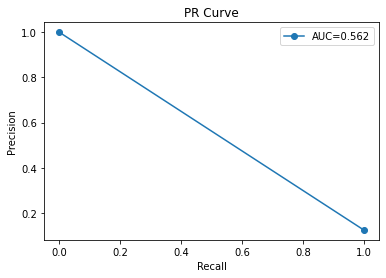

In [ ]:
auc, pr = calc_auc(pred_bbox, true_bbox)
plt.plot(pr[:,0], pr[:,1], 'o-', label=f'AUC={auc:.3f}')
plt.title('PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Non-Maximum Suppression

In [ ]:
def nms(detections_dictionary, iou_thr=0.05):
    """
    :param detections_dictionary: dict of bboxes in format {filename: detections}
        detections is a N x 5 array, where N is number of detections. Each
        detection is described using 5 numbers: [row, col, n_rows, n_cols,
        confidence].
    :param iou_thr: IoU threshold for nearby detections
    :return: dict in same format as detections_dictionary where close detections
        are deleted
    """
    # your code here \/
    detections_filtered = {}

    for filename, detections in detections_dictionary.items():
        # (1)
        detections_sorted = sorted(detections, key=lambda x: x[-1], reverse=True)
        # (2)
        N = len(detections_sorted)
        mask = [True] * N
        for i in range(N):
            if mask[i]:
                for j in range(i+1, N):
                    current = detections_sorted[i][:-1]
                    next = detections_sorted[j][:-1]
                    iou = calc_iou(current, next)
                    if iou > iou_thr:
                        mask[j] = False
        filtered = [d for m, d in zip(mask, detections_sorted) if m]
        detections_filtered[filename] = filtered
    return detections_filtered

In [ ]:
predictions = {"1":[[0.0, 0.0, 40.0, 100.0, 0.0001439873068488249],
                [0.0, 0.0, 40.0, 100.0, 0.0001439873068488249],
                [0.0, 8.0, 40.0, 100.0, 8.844506876789047e-05],
                [0.0, 12.0, 40.0, 100.0, 8.864786832494879e-05],
                [0.0, 16.0, 40.0, 100.0, 5.646329540611465e-05],
                [0.0, 20.0, 40.0, 100.0, 5.32966834220056e-05],
                [0.0, 24.0, 40.0, 100.0, 3.776895335082916e-05],
                [0.0, 12.0, 40.0, 100.0, 8.864786832494879e-05],
                [0.0, 24.0, 40.0, 100.0, 3.776895335082916e-05],
                [0.0, 16.0, 40.0, 100.0, 5.646329540611465e-05],
                [0.0, 32.0, 40.0, 100.0, 2.122202754350387e-05],
                [0.0, 20.0, 40.0, 100.0, 5.32966834220056e-05],
                [0.0, 20.0, 40.0, 100.0, 5.32966834220056e-05],
                [0.0, 16.0, 40.0, 100.0, 5.646329540611465e-05],
                [0.0, 28.0, 40.0, 100.0, 2.6099790148424712e-05],
                [0.0, 52.0, 40.0, 100.0, 1.1105166866133818e-05],
                [0.0, 24.0, 40.0, 100.0, 3.776895335082916e-05],
                [0.0, 0.0, 40.0, 100.0, 0.0001439873068488249],
                [0.0, 68.0, 40.0, 100.0, 7.211932406036818e-06],
                [0.0, 64.0, 40.0, 100.0, 6.360868819693369e-06]]}
true_nms = [[0, 0, 40, 100], [0, 28, 40, 100], [0, 68, 40, 100]]

In [ ]:
nms(predictions, 0.6)['1']

[[0.0, 0.0, 40.0, 100.0, 0.0001439873068488249],
 [0.0, 28.0, 40.0, 100.0, 2.6099790148424712e-05],
 [0.0, 68.0, 40.0, 100.0, 7.211932406036818e-06]]

## Comparison before/after NMS

In [ ]:
true_bb = {k: v[1] for k, v in data.items()}
sample = dict(list(detections.items())[:3])
sample_nms = nms(sample, 0.1)

auc_before, pr_before = calc_auc(sample, true_bb)
auc_after, pr_after = calc_auc(sample_nms, true_bb)
print(f'AUC before = {auc_before:.3f}, AUC after = {auc_after:.3f}')

for name, dets in sample.items():
    print(f'{name} -> {len(dets)} detections, {len(sample_nms[name])} after NMS, {len(data[name][1])} gt cars')

AUC before = 0.526, AUC after = 1.000
test-0.png -> 104 detections, 2 after NMS, 1 gt cars
test-1.png -> 145 detections, 3 after NMS, 2 gt cars
test-2.png -> 48 detections, 1 after NMS, 1 gt cars


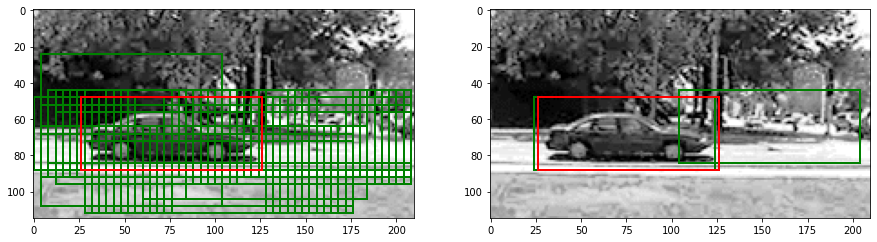

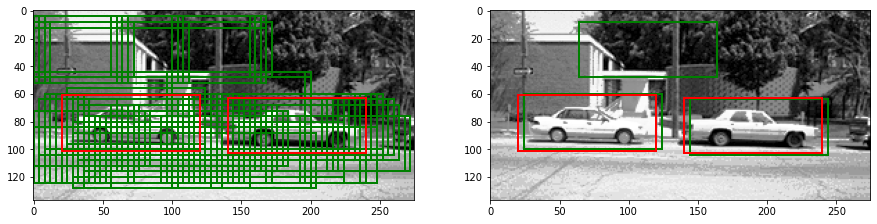

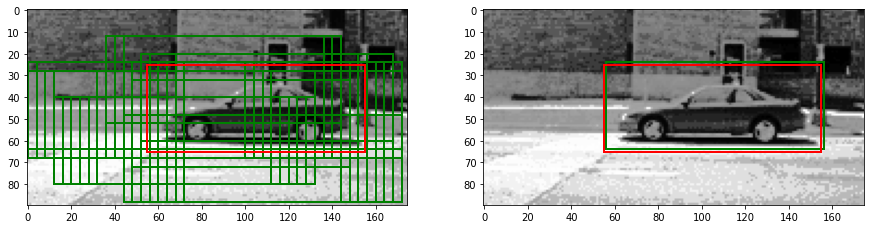

In [ ]:
for name, dets in sample.items():
    img = dictionary_of_images[name]
    dets_nms = sample_nms[name]
    gt = data[name][1]
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].imshow(img, cmap='gray')
    for det in dets:
        h, w, height, width, _ = det
        ax[0].add_patch(Rectangle((w, h), width, height, linewidth=2, edgecolor='g', facecolor='none'))
    for car in gt:
        h, w, height, width = car
        ax[0].add_patch(Rectangle((w, h), width, height, linewidth=2, edgecolor='r', facecolor='none'))

    ax[1].imshow(img, cmap='gray')
    for det in dets_nms:
        h, w, height, width, _ = det
        ax[1].add_patch(Rectangle((w, h), width, height, linewidth=2, edgecolor='g', facecolor='none'))
    for car in gt:
        h, w, height, width = car
        ax[1].add_patch(Rectangle((w, h), width, height, linewidth=2, edgecolor='r', facecolor='none'))

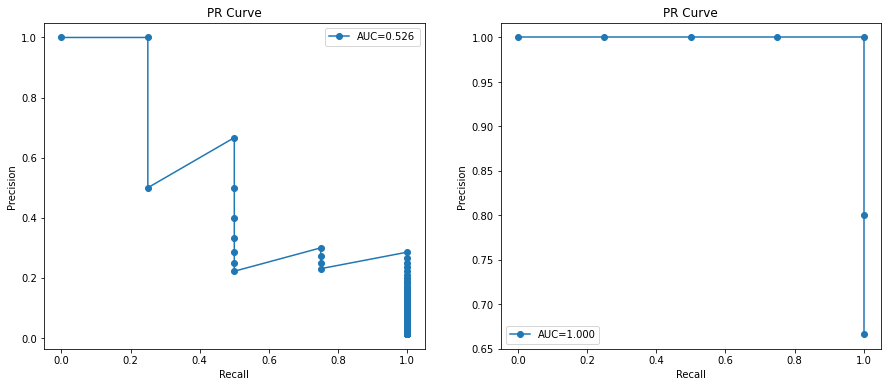

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

ax[0].plot(pr_before[:,0], pr_before[:,1], 'o-', label=f'AUC={auc_before:.3f}')
ax[0].set_title('PR Curve')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].legend()

ax[1].plot(pr_after[:,0], pr_after[:,1], 'o-', label=f'AUC={auc_after:.3f}')
ax[1].set_title('PR Curve')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend()

plt.show()